# Recommendation Systems

A recommendation system is an algorithm designed to suggest items to users. By the growth of data, it could be done based on the past favorite items, similarities to other users, or other behaviors. One application of recommendation systems is in e-commerce ,where the items here are products.

In this notebook, we use this algorithm for [MovieLens](https://movielens.org) dataset. We have a list of ratings (integer from $1$ to $5$) from some users to some movies. Our goal is to recommend movies to users such that they will find them helpful.

## Table of Contents

- 1- Content Filtering and Collaborative Filtering
- 2- SVD for Collaborative Filtering
  - 2.1- Load data
  - 2.2- Preprocess data
  - 2.3- SVD model
  - 2.4- Train
  - 2.5- Recommend

## 1- Content Filtering and Collaborative Filtering

There are many approaches for recommender systems.

**Content Filtering** is based on the features of items and the user’s past interactions. A user who watches romantic movies may like other romantic movies.

**Collaborative Filtering** is based on the behavior of other users. If two users watched many movies similarly, a movie liked by one user, probably the other user also like it.

## 2- SVD for Collaborative Filtering

In this notebook, we use collaborative filtering.

First, let's import needed libraries.

- [numpy](https://numpy.org): The fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org): Easy to use data analysis and manipulation tool.
- [matplotlib](https://matplotlib.org): For creating visualizations in Python.
- [sklearn](https://scikit-learn.org/stable/): We just use its split method.
- [tqdm](https://tqdm.github.io): Make loops show a smart progress meter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import trange

### 2.1- Load data

Now, we load the ratings in a pandas DataFrame. There are $3$ columns that we will deal with: `userId`, `movieId`, and `rating`. In each row, a user rates a movie. Remove `timestamp` column. Find the total number of rows available. Show the first $5$ rows.

In [2]:
path = 'ml-latest-small/ratings.csv'
df = pd.read_csv(path).drop('timestamp', axis=1)
print(f'There are {len(df)} ratings.')
df.head()

There are 100836 ratings.


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 2.2- Preprocess data

It is necessary that user ids be in $\{0, 1, ..., N-1\}$, and item ids in $\{0, 1, ..., M-1\}$, while there are $N$ unique users and $M$ unique ids. Find $N, M$ and preprocess ids.

In [3]:
user_ids = df['userId'].unique()
item_ids = df['movieId'].unique()

user_map = {user: idx for idx, user in enumerate(user_ids)}
item_map = {item: idx for idx, item in enumerate(item_ids)}

df['userId'] = df['userId'].map(user_map)
df['movieId'] = df['movieId'].map(item_map)

N, M = len(user_ids), len(item_ids)
print(f'There are {N} unique users and {M} unique items')

There are 610 unique users and 9724 unique items


We keep $20\%$ of ratings for validation to see our algorithm's performance on unseen data. Find the number of training and validation examples.

In [4]:
random_state = 42
df_train, df_val = train_test_split(df, test_size=0.2, random_state=random_state)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
print(f'Train size={len(df_train)}, Validation size={len(df_val)}')

Train size=80668, Validation size=20168


### 2.3- SVD model

In terms of matrices, we have the rating matrix $R \in \mathbb{R}^{N\times M}$. The $i$-th row of this matrix is the $i$-th user ratings for every movie. The challenge is that, we don't have some of the entries of $R$. We want to find some valuable features based on the available ratings to find the missing entries.

Think of the SVD for $R=U\Sigma V^T$ as user-feature matrix $U$, feature importance $\Sigma$, and item-feature matrix $V^T$. By selecting the top $k$ features, we reduce the dimensionality and capture latent factors representing user and item features. But we will solve this problem in a different manner.

We represent the predicted rating of the user $u$ to the item $i$ as $\hat{r}_{ui}$, the dot product of $p_u, q_i \in \mathbb{R}^{k}$. According to the [Low-rank approximation](https://en.wikipedia.org/wiki/Low-rank_approximation), the best performance we can achieve by this setting is equal to SVD. We add user $b_u$ and item $c_i$ bias for more flexibility.
$$
\hat{r}_{ui} = p_u^Tq_i + b_u + c_i
$$
The objective is to minimize the below loss function:
$$
\mathcal{L} = \sum_{u, i} \big[ (r_{ui} - \hat{r}_{ui})^2 + \lambda (b_u^2 + c_i^2 + ||p_u||^2 + ||q_i||^2) \big]
$$
where $\lambda$ is the regularization parameter and $||.||$ is the $l$-2 norm.

Store the above parameters in a class and implement `forward` and `backward` methods. You should use `np.random.randn` for parameter initialization.

In [5]:
class CollaborativeFiltering:
    def __init__(self, N, M, k, lr, _lambda):
        self.P = np.random.randn(N, k)
        self.Q = np.random.randn(M, k)
        self.b = np.random.randn(N)
        self.c = np.random.randn(M)
        self.lr = lr
        self._lambda = _lambda

    def forward(self, u, i):
        return np.dot(self.P[u], self.Q[i]) + self.b[u] + self.c[i]

    def backward(self, u, i, r):
        e = self.forward(u, i) - r
        self.b[u] -= self.lr * (e + self._lambda * self.b[u])
        self.c[i] -= self.lr * (e + self._lambda * self.c[i])

        self.P[u] -= self.lr * (e * self.Q[i] + self._lambda * self.P[u])
        self.Q[i] -= self.lr * (e * self.P[u] + self._lambda * self.Q[i])

k = 20
lr = 0.005
_lambda = 0.02
model = CollaborativeFiltering(N, M, k, lr, _lambda)

### 2.4- Train

Use Stochastic Gradient Descent to update the parameters of the model.

Evaluate your model with RMSE on validation set:
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{j=1}^n (r - \hat{r})^2}
$$
where $n$ is the number of examples in validation set.

In [6]:
def train(model: CollaborativeFiltering, df_train: pd.DataFrame):
    for _, u, i, r in df_train.itertuples():
        model.backward(u, i, r)

def evaluate(model: CollaborativeFiltering, df_val: pd.DataFrame):
    y_true = []
    y_pred = []
    for _, u, i, r in df_val.itertuples():
        r_hat = model.forward(u, i)
        y_true.append(r)
        y_pred.append(r_hat)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def plot(y):
    plt.plot(range(1, len(y)+1), y)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Collaborative Filtering with SVD')
    plt.show()

Each epoch should be done in about one second. The final RSME should be about $1.3$.

Training: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


Final RMSE: 1.3022


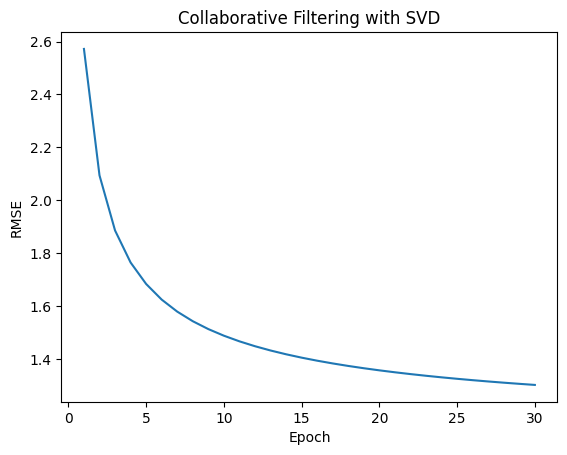

In [7]:
RMSEs = []
num_epochs = 30

for epoch in trange(num_epochs, desc='Training'):
    train(model, df_train)
    rmse = evaluate(model, df_val)
    RMSEs.append(rmse)

print(f'Final RMSE: {RMSEs[-1]:.4f}')
plot(RMSEs)

### 2.5- Recommend

The below cell will compare the unseen ratings with the predictions.

In [8]:
def get_candidate_items(user_id):
    rows = df_val[df_val['userId'] == user_id]
    return rows['movieId'], rows['rating']

def recommend_for_user(model, user_id):
    candidate_items, real_ratings = get_candidate_items(user_id)
    pred_ratings = []
    for i in candidate_items:
        r_hat = model.forward(user_id, i)
        pred_ratings.append(r_hat)
    result = pd.DataFrame({
        'Item Id': candidate_items,
        'Real Rating': real_ratings,
        'Pred Rating': pred_ratings
    })
    return result

result = recommend_for_user(model, 200)
result

,Item Id,Real Rating,Pred Rating
51,539,3.0,2.876285
622,355,4.0,4.400043
758,392,4.0,5.096680
1884,33,3.0,4.258089
1897,130,4.0,2.484797
2396,1583,5.0,5.017656
3188,730,4.0,2.037693
3775,173,3.0,1.303144
4264,100,4.0,4.855305
5632,271,4.0,2.677795


Good predictions! There are better techniques for collaborative filtering using neural networks. For more information see [this](https://www.nvidia.com/en-us/glossary/recommendation-system/) blog. As this blog said, recommender systems have very huge impact on the amount of sales for companies. I hope you find this notebook helpful. Thanks!